# Object detection and masking from prompts with GroundedSAM (GroundingDINO + SAM) and OpenVINO

In this notebook, we provide the OpenVINO™ optimization for the combination of GroundingDINO + SAM = [GroundedSAM](https://github.com/IDEA-Research/Grounded-Segment-Anything) on Intel® platforms. 

GroundedSAM aims to detect and segment anything with text inputs. GroundingDINO is a language-guided query selection module to enhance object detection using input text. It selects relevant features from image and text inputs and returns predicted boxes with detections. The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. We use box predictions from GroundingDINO to mask the original image.

More details about the model can be found in the [paper](https://arxiv.org/abs/2401.14159), and the official [repository](https://github.com/IDEA-Research/Grounded-Segment-Anything).

![image](https://github.com/openvinotoolkit/openvino_notebooks/assets/5703039/3c19063a-c60a-4d5d-b534-e1305a854180)

#### Table of contents:
- [Clone repository and install requirements](#Clone-repository-and-install-requirements)
- [Download checkpoints and load PyTorch model](#Download-checkpoints-and-load-PyTorch-model)
- [Convert GroundingDINO to OpenVINO IR format](#Convert-GroundingDINO-to-OpenVINO-IR-format)
- [Run OpenVINO optimized GroundingDINO](#Run-OpenVINO-optimized-GroundingDINO)
- [Convert SAM to OpenVINO IR](#Convert-SAM-to-OpenVINO-IR)
- [Combine GroundingDINO + SAM (GroundedSAM)](#Combine-GroundingDINO-+-SAM-(GroundedSAM))
- [Interactive GroundedSAM](#Interactive-GroundedSAM)
- [Cleanup](#Cleanup)


### Clone repositories and install requirements
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q timm --extra-index-url https://download.pytorch.org/whl/cpu  # is needed for torch
%pip install -q "openvino>=2024.0" opencv-python supervision transformers yapf pycocotools addict gradio

For faster computation and to limit RAM by default we use `EfficientSAM` for segmentation, but if you wish more accurate segmentation you can select vanilla `SAM`.

In [2]:
import ipywidgets

sam_type_widget = ipywidgets.Dropdown(
    options=['EfficientSAM', 'SAM'],
    value='EfficientSAM',
    description='Segment Anything type:',
)
sam_type_widget

Dropdown(description='Segment Anything type:', options=('EfficientSAM', 'SAM'), value='EfficientSAM')

In [3]:
use_efficient_sam = sam_type_widget.value == 'EfficientSAM'

In [4]:
from pathlib import Path
import sys
import os

repo_dir = Path("Grounded-Segment-Anything")
ground_dino_dir = Path('GroundingDINO')
efficient_sam_dir = Path('EfficientSAM')

# we use grounding dino from a fork which contains modifications that allow conversion to OpenVINO IR format
if not ground_dino_dir.exists():
    !git clone https://github.com/wenyi5608/GroundingDINO/
if use_efficient_sam and not efficient_sam_dir.exists():
    !git clone https://github.com/yformer/EfficientSAM
if not use_efficient_sam and not repo_dir.exists():
    !git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

# append to sys.path so that modules from the repo could be imported
sys.path.append(str(ground_dino_dir))
sys.path.append(str('EfficientSAM' if use_efficient_sam else repo_dir / 'segment_anything'))

In [5]:
import torch
import numpy as np
import supervision as sv
import openvino as ov
from PIL import Image, ImageDraw, ImageFont
from typing import Union, List
import transformers

core = ov.Core()

### Download checkpoints and load PyTorch models
[back to top ⬆️](#Table-of-contents:)

In [6]:
IRS_PATH = Path('openvino_irs')
CKPT_BASE_PATH = Path('checkpoints')
os.makedirs(IRS_PATH, exist_ok=True)
os.makedirs(CKPT_BASE_PATH, exist_ok=True)

PT_DEVICE = 'cpu'
ov_dino_name = 'openvino_grounding_dino'
ov_sam_name = 'openvino_segment_anything'

ground_dino_img_size = (1024, 1280)

# GroundingDINO config and checkpoint 
GROUNDING_DINO_CONFIG_PATH = f"{repo_dir}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = CKPT_BASE_PATH / "groundingdino_swint_ogc.pth"

# Segment Anything checkpoint
SAM_CHECKPOINT_PATH = CKPT_BASE_PATH / "sam_vit_h_4b8939.pth"

# Efficient Segment Anything checkpoint
EFFICIENT_SAM_CHECKPOINT_PATH = efficient_sam_dir / "weights/efficient_sam_vitt.pt"

In [ ]:
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file

download_file("https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth", directory=CKPT_BASE_PATH)
if not use_efficient_sam:
    download_file("https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth", directory=CKPT_BASE_PATH)

GroundingDINO imports

In [ ]:
from groundingdino.models.GroundingDINO.bertwarper import generate_masks_with_special_tokens_and_transfer_map
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util import get_tokenlizer
from groundingdino.util.utils import get_phrases_from_posmap
from groundingdino.util.inference import Model

In [9]:
def load_pt_grounding_dino(model_config_path, model_checkpoint_path, cpu_only=True):
    args = SLConfig.fromfile(model_config_path)
    
    # modified config
    args.device = PT_DEVICE
    args.use_checkpoint = False
    args.use_transformer_ckpt = False
    
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    _ = model.eval()

    return model, args.max_text_len, get_tokenlizer.get_tokenlizer(args.text_encoder_type)

In [10]:
# load extension to skip manually specific cells when EfficientSAM is used
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/skip_kernel_extension.py',
    filename='skip_kernel_extension.py'
)

%load_ext skip_kernel_extension

In [ ]:
# Load GroundingDINO inference model
pt_grounding_dino_model, max_text_len, dino_tokenizer = load_pt_grounding_dino(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)

In [12]:
# load SAM model: EfficientSAM or vanilla SAM

if use_efficient_sam:
    from efficient_sam.efficient_sam import build_efficient_sam
    # Load EfficientSAM
    efficient_sam_model = build_efficient_sam(
        encoder_patch_embed_dim=192, 
        encoder_num_heads=3, 
        checkpoint=EFFICIENT_SAM_CHECKPOINT_PATH
    ).eval()
else:
    from segment_anything import build_sam, SamPredictor
    # Load SAM Model and SAM Predictor
    sam = build_sam(checkpoint=SAM_CHECKPOINT_PATH).to(PT_DEVICE)
    sam_predictor = SamPredictor(sam)

### Convert GroundingDINO to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

In order to convert valid example inputs are necessary

In [13]:
ov_dino_path = IRS_PATH / f'{ov_dino_name}.xml'

if not ov_dino_path.exists():
    tokenized = pt_grounding_dino_model.tokenizer(["the running dog ."], return_tensors="pt")
    input_ids = tokenized['input_ids']
    token_type_ids = tokenized['token_type_ids']
    attention_mask = tokenized['attention_mask']
    position_ids = torch.arange(input_ids.shape[1]).reshape(1, -1)
    text_token_mask = torch.randint(0, 2, (1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.bool)
    img = torch.randn(1, 3, *ground_dino_img_size)
    
    dummpy_inputs = img, input_ids, attention_mask, position_ids, token_type_ids, text_token_mask

    pt_grounding_dino_model.eval()
    for par in pt_grounding_dino_model.parameters():
        par.requires_grad = False
    traced_model = torch.jit.trace(pt_grounding_dino_model, example_inputs=dummpy_inputs, strict=False, check_trace=False)

    ov_dino_model = ov.convert_model(traced_model, example_input=dummpy_inputs)
    ov.save_model(ov_dino_model, ov_dino_path)
else:
    ov_dino_model = core.read_model(ov_dino_path)

### Run OpenVINO optimized GroundingDINO
[back to top ⬆️](#Table-of-contents:)

In [14]:
device_widget = ipywidgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
)
device_widget

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In order to run inference `ov_dino_model` should be compiled. Resulting `ov.CompiledModel` object receives the same arguments as pytorch `forward`/`__call__` methods.

In [15]:
device = device_widget.value
ov_compiled_grounded_dino = core.compile_model(ov_dino_model, device.upper())

We will reuse only tokenizer from the original GroundingDINO model class, but the inference will be done using OpenVINO optimized model.

In [16]:
def transform_image(pil_image: Image.Image) -> torch.Tensor:
    import groundingdino.datasets.transforms as T
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(pil_image, None)  # 3, h, w
    return image

def get_ov_grounding_output(
    model: ov.CompiledModel, 
    pil_image: Image.Image, 
    caption: Union[str, List[str]], 
    box_threshold: float, 
    text_threshold: float,
    dino_tokenizer: transformers.PreTrainedTokenizerBase = dino_tokenizer,
    max_text_len: int = max_text_len
) -> (torch.Tensor, List[str], torch.Tensor):
    #  for text prompt pre-processing we reuse existing routines from GroundignDINO repo
    if isinstance(caption, list):
        caption = '. '.join(caption)
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    captions = [caption]
        
    tokenized = dino_tokenizer(captions, padding="longest", return_tensors="pt")
    specical_tokens = dino_tokenizer.convert_tokens_to_ids(["[CLS]", "[SEP]", ".", "?"])
    
    (
        text_self_attention_masks,
        position_ids,
        cate_to_token_mask_list,
    ) = generate_masks_with_special_tokens_and_transfer_map(
        tokenized, specical_tokens, dino_tokenizer)

    if text_self_attention_masks.shape[1] > max_text_len:
        text_self_attention_masks = text_self_attention_masks[
            :, : max_text_len, : max_text_len]
        
        position_ids = position_ids[:, : max_text_len]
        tokenized["input_ids"] = tokenized["input_ids"][:, : max_text_len]
        tokenized["attention_mask"] = tokenized["attention_mask"][:, : max_text_len]
        tokenized["token_type_ids"] = tokenized["token_type_ids"][:, : max_text_len]

    # inputs dictionary which will be fed into the ov.CompiledModel for inference
    inputs = {}
    inputs["attention_mask.1"] = tokenized["attention_mask"]
    inputs["text_self_attention_masks"] = text_self_attention_masks 
    inputs["input_ids"] = tokenized["input_ids"]
    inputs["position_ids"] = position_ids
    inputs["token_type_ids"] = tokenized["token_type_ids"]
    
    # GroundingDINO fails to run with input shapes different than one used for conversion. 
    # As a workaround we resize input_image to the size used for conversion. Model does not rely
    # on image resolution to know object sizes therefore no need to resize box_predictions
    from torchvision.transforms.functional import resize, InterpolationMode
    input_img = resize(transform_image(pil_image), ground_dino_img_size, interpolation=InterpolationMode.BICUBIC)[None, ...]
    inputs["samples"] = input_img

    # OpenVINO inference
    request = model.create_infer_request()
    request.start_async(inputs, share_inputs=False)
    request.wait()
    
    def sig(x):
        return 1 / (1 + np.exp(-x))
    
    logits = torch.from_numpy(sig(np.squeeze(request.get_tensor("pred_logits").data, 0)))
    boxes =  torch.from_numpy(np.squeeze(request.get_tensor("pred_boxes").data, 0))
    
    # filter output
    filt_mask = logits.max(dim=1)[0] > box_threshold
    logits, boxes = logits[filt_mask], boxes[filt_mask]

    # get phrase and build predictions
    tokenized = dino_tokenizer(caption)
    pred_phrases = []
    for logit in logits:
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, dino_tokenizer)
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")

    return boxes, pred_phrases, logits.max(dim=1)[0]

In [17]:
SOURCE_IMAGE_PATH = f"{repo_dir}/assets/demo7.jpg"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

pil_image = Image.open(SOURCE_IMAGE_PATH)
classes_prompt = ["Horse", "Cloud"]

In [18]:
boxes_filt, pred_phrases, logits_filt = get_ov_grounding_output(
    ov_compiled_grounded_dino,
    pil_image,
    classes_prompt,
    BOX_THRESHOLD, TEXT_THRESHOLD
)

Convert predicted boxes to supervision box detections format

In [19]:
source_w, source_h = pil_image.size
detections = Model.post_process_result(
    source_h=source_h,
    source_w=source_w,
    boxes=boxes_filt,
    logits=logits_filt)

class_id = Model.phrases2classes(phrases=pred_phrases, classes=list(map(str.lower, classes_prompt)))
detections.class_id = class_id

Draw box detections

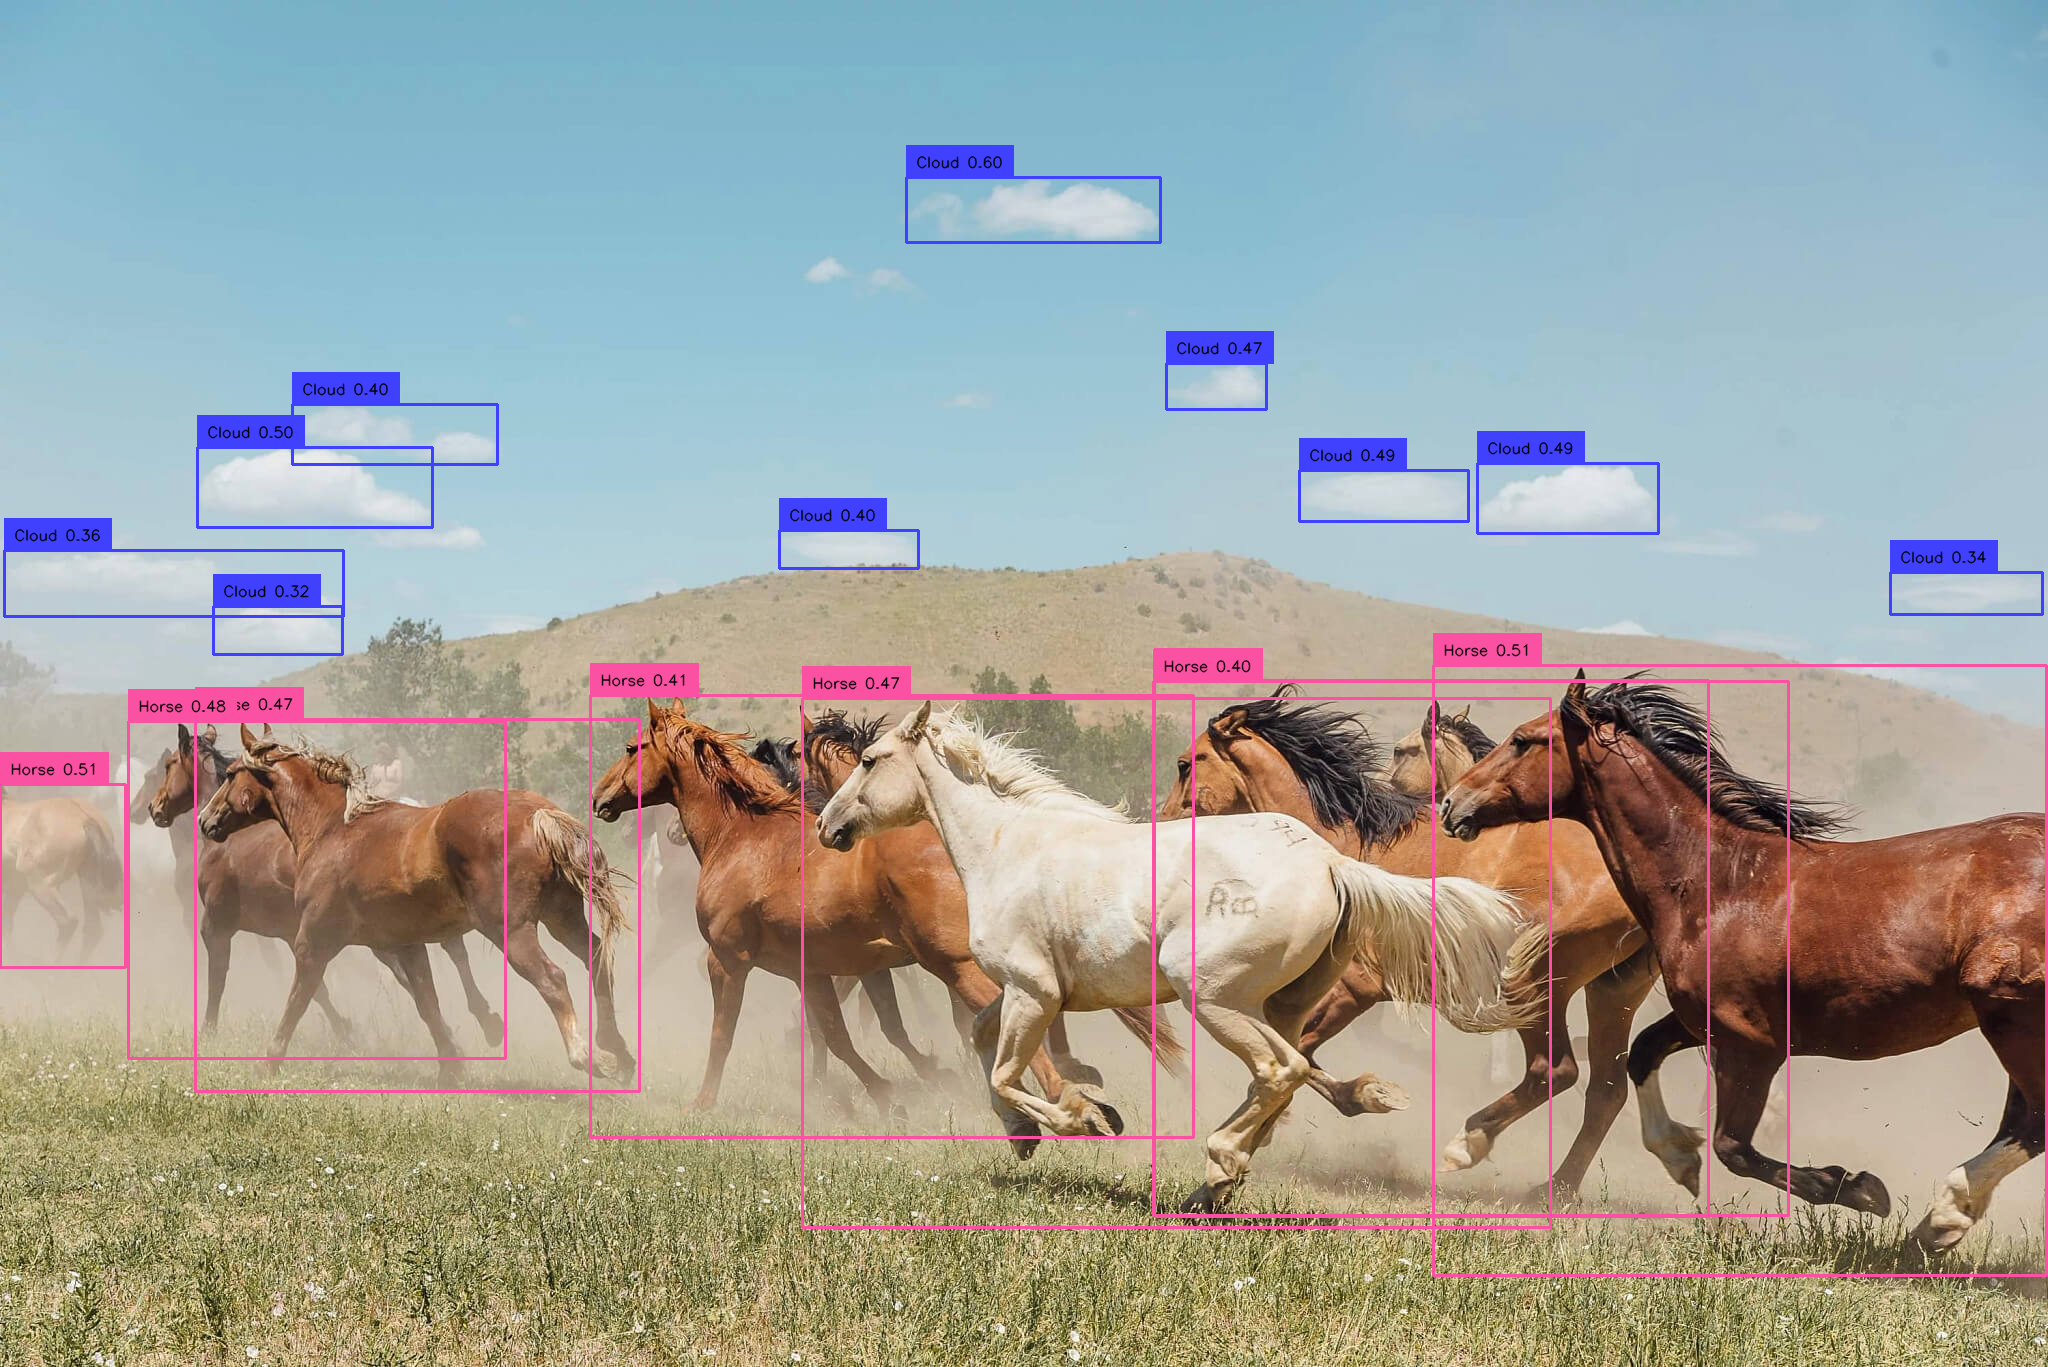

In [20]:
box_annotator = sv.BoxAnnotator()
labels = [
    f"{classes_prompt[class_id] if class_id is not None else 'None'} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _
    in detections]
annotated_frame = box_annotator.annotate(scene=np.array(pil_image).copy(), detections=detections, labels=labels)

Image.fromarray(annotated_frame)

Great! All clouds and horses are detected. Feel free to play around and specify other objects you wish to detect.

### Convert SAM to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

And now let's feed those detection to `SAM` model. We will use `EfficiendSAM` for faster computation and to save ram, but feel free to select vanilla `SAM` if you wish more detailed and precise segmentation. First of all let's convert `SAM` model to OpenVINO IR.

In [ ]:
%%skip not $use_efficient_sam

ov_efficient_sam_name = 'openvino_efficient_sam'
ov_efficient_sam_path = IRS_PATH / f'{ov_efficient_sam_name}.xml'

# convert EfficientSAM to OpenVINO IR format
if not ov_efficient_sam_path.exists():
    random_input_image = np.random.rand(1, 3, *pil_image.size[::-1]).astype(np.float32)
    bounding_box = np.array([900, 100, 1000, 200]).reshape([1, 1, 2, 2])
    bbox_labels = np.array([2, 3]).reshape([1, 1, 2])
    efficient_sam_dummy_input = tuple(torch.from_numpy(x) for x in (random_input_image, bounding_box, bbox_labels))

    ov_efficient_sam = ov.convert_model(efficient_sam_model, example_input=efficient_sam_dummy_input)
    ov.save_model(ov_efficient_sam, ov_efficient_sam_path)
else:
    ov_efficient_sam = core.read_model(ov_efficient_sam_path)

compiled_efficient_sam = core.compile_model(ov_efficient_sam, 'CPU')

Below is conversion of vanilla `SAM`. These cells are inactive if `EfficientSAM` is selected for segmentation.

In [22]:
%%skip $use_efficient_sam

# In order to convert to OpenVINO IR neeed to patch forward method or the torch.nn.Module for SAM
class SamMaskFromBoxes(torch.nn.Module):
    def __init__(
        self,
        sam_predictor,
    ) -> None:
        super().__init__()
        self.model = sam_predictor

    @torch.no_grad()
    def forward(
        self,
        input_image: torch.Tensor,
        transformed_boxes: torch.Tensor,
        multimask_output: bool = False,
        hq_token_only: bool = False,
    ):
        pre_processed_image = self.model.model.preprocess(input_image)
        image_embeddings, interm_features = self.model.model.image_encoder(pre_processed_image)
        
        # Embed prompts
        sparse_embeddings, dense_embeddings = self.model.model.prompt_encoder(
            points=None,
            boxes=transformed_boxes,
            masks=None,
        )

        # Predict masks
        low_res_masks, iou_predictions = self.model.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output,
            hq_token_only=hq_token_only,
            interm_embeddings=interm_features,
        )

        return low_res_masks, iou_predictions

In [23]:
%%skip $use_efficient_sam

ov_sam_path = IRS_PATH / f'{ov_sam_name}.xml'

# Load pytorch model object and prepare example input for conversion
exportable = SamMaskFromBoxes(sam_predictor)
exportable.model.model.eval()
for par in exportable.model.model.parameters():
    par.requires_grad = False

example_image = np.array(Image.open(SOURCE_IMAGE_PATH).convert("RGB"))
transfromed_example_image = exportable.model.transform.apply_image(example_image)
input_image_torch = torch.as_tensor(transfromed_example_image, device=PT_DEVICE)
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

dummy_transformed_boxes = torch.rand(1, 4, dtype=torch.float32) * 200

# convert vanilla SAM to OpenVINO IR format
if not ov_sam_path.exists():   
    traced = torch.jit.trace(exportable, example_inputs=(input_image_torch, dummy_transformed_boxes))
    ov_sam = ov.convert_model(traced, example_input=(input_image_torch, dummy_transformed_boxes))
    ov.save_model(ov_sam, ov_sam_path)
else:
    ov_sam = core.read_model(ov_sam_path)

compiled_vanilla_sam = core.compile_model(ov_sam, device_name=device)


### Combine GroundingDINO + SAM (GroundedSAM)
[back to top ⬆️](#Table-of-contents:)

We have OpenVINO IRs for both GroundingDINO and SAM models. Lets run the segmentation using predicitons from GroundingDINO. Same as above, use `EfficientSAM` by default.

In [24]:
def predict_efficient_sam_mask(compiled_efficient_sam: ov.CompiledModel, image: Image.Image, bbox: torch.Tensor):
    # input image is scaled so that none of the sizes is greater than 1024, same as in 274-efficient-sam notebook
    input_size = 1024  
    w, h = image.size[:2]
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))
    
    numpy_image = np.array(image, dtype=np.float32) / 255.0
    numpy_image = np.transpose(numpy_image, (2, 0, 1))[None, ...]

    scaled_points = bbox * scale

    bounding_box = scaled_points.reshape([1, 1, 2, 2])
    bbox_labels = np.reshape(np.array([2, 3]), [1, 1, 2])

    res = compiled_efficient_sam((numpy_image, bounding_box, bbox_labels))

    predicted_logits, predicted_iou = res[0], res[1]

    all_masks = torch.ge(torch.sigmoid(torch.from_numpy(predicted_logits[0, 0, :, :, :])), 0.5).numpy()
    predicted_iou = predicted_iou[0, 0, ...]

    # select the mask with the greatest IOU
    max_predicted_iou = -1
    selected_mask_using_predicted_iou = None
    for m in range(all_masks.shape[0]):
        curr_predicted_iou = predicted_iou[m]
        if (
            curr_predicted_iou > max_predicted_iou
            or selected_mask_using_predicted_iou is None
        ):
            max_predicted_iou = curr_predicted_iou
            selected_mask_using_predicted_iou = all_masks[m]
    return selected_mask_using_predicted_iou

# If several detections are fed to EfficientSAM, it merges them to a single mask. Therefore, we call it one by one for each detection.
def predict_efficient_sam_masks(compiled_efficient_sam: ov.CompiledModel, pil_image: Image.Image, transformed_boxes) -> torch.Tensor:
    masks = []
    for bbox in transformed_boxes:
        mask = predict_efficient_sam_mask(compiled_efficient_sam, pil_image, bbox)
        mask = Image.fromarray(mask).resize(pil_image.size)
        masks.append(np.array(mask))
    masks = torch.from_numpy(np.array(masks))
    return masks

In [25]:
def transform_boxes(sam_predictor: torch.nn.Module, boxes: torch.Tensor, size: tuple) -> torch.Tensor:
    H, W = size[0], size[1]
    for i in range(boxes.size(0)):
        boxes[i] = boxes[i] * torch.Tensor([W, H, W, H])
        boxes[i][:2] -= boxes[i][2:] / 2
        boxes[i][2:] += boxes[i][:2]

    return sam_predictor.transform.apply_boxes_torch(boxes, size).to(PT_DEVICE)

def predict_vanilla_sam_masks(compiled_vanilla_sam: ov.CompiledModel, image: np.ndarray, transformed_boxes: torch.Tensor) -> torch.Tensor:
    transfromed_image = exportable.model.transform.apply_image(image)
    input_image_torch = torch.as_tensor(transfromed_image, device=PT_DEVICE)
    input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    original_size = tuple(image.shape[:2])
    input_size = tuple(input_image_torch.shape[-2:])

    low_res_masks = compiled_vanilla_sam((input_image_torch, transformed_boxes))[0]
    
    # Upscale the masks to the original image resolution
    masks = exportable.model.model.postprocess_masks(torch.from_numpy(low_res_masks), input_size, original_size)
    masks = masks > exportable.model.model.mask_threshold
    return masks

In [26]:
if use_efficient_sam:
    masks = predict_efficient_sam_masks(compiled_efficient_sam, pil_image, detections.xyxy)
    detections.mask = masks.numpy()
else:
    transformed_boxes = transform_boxes(sam_predictor, boxes_filt, pil_image.size[::-1])
    masks = predict_vanilla_sam_masks(compiled_vanilla_sam, np.array(pil_image), transformed_boxes)
    detections.mask = masks[:, 0].numpy()

Combine both boxes and segmentation masks and draw them.

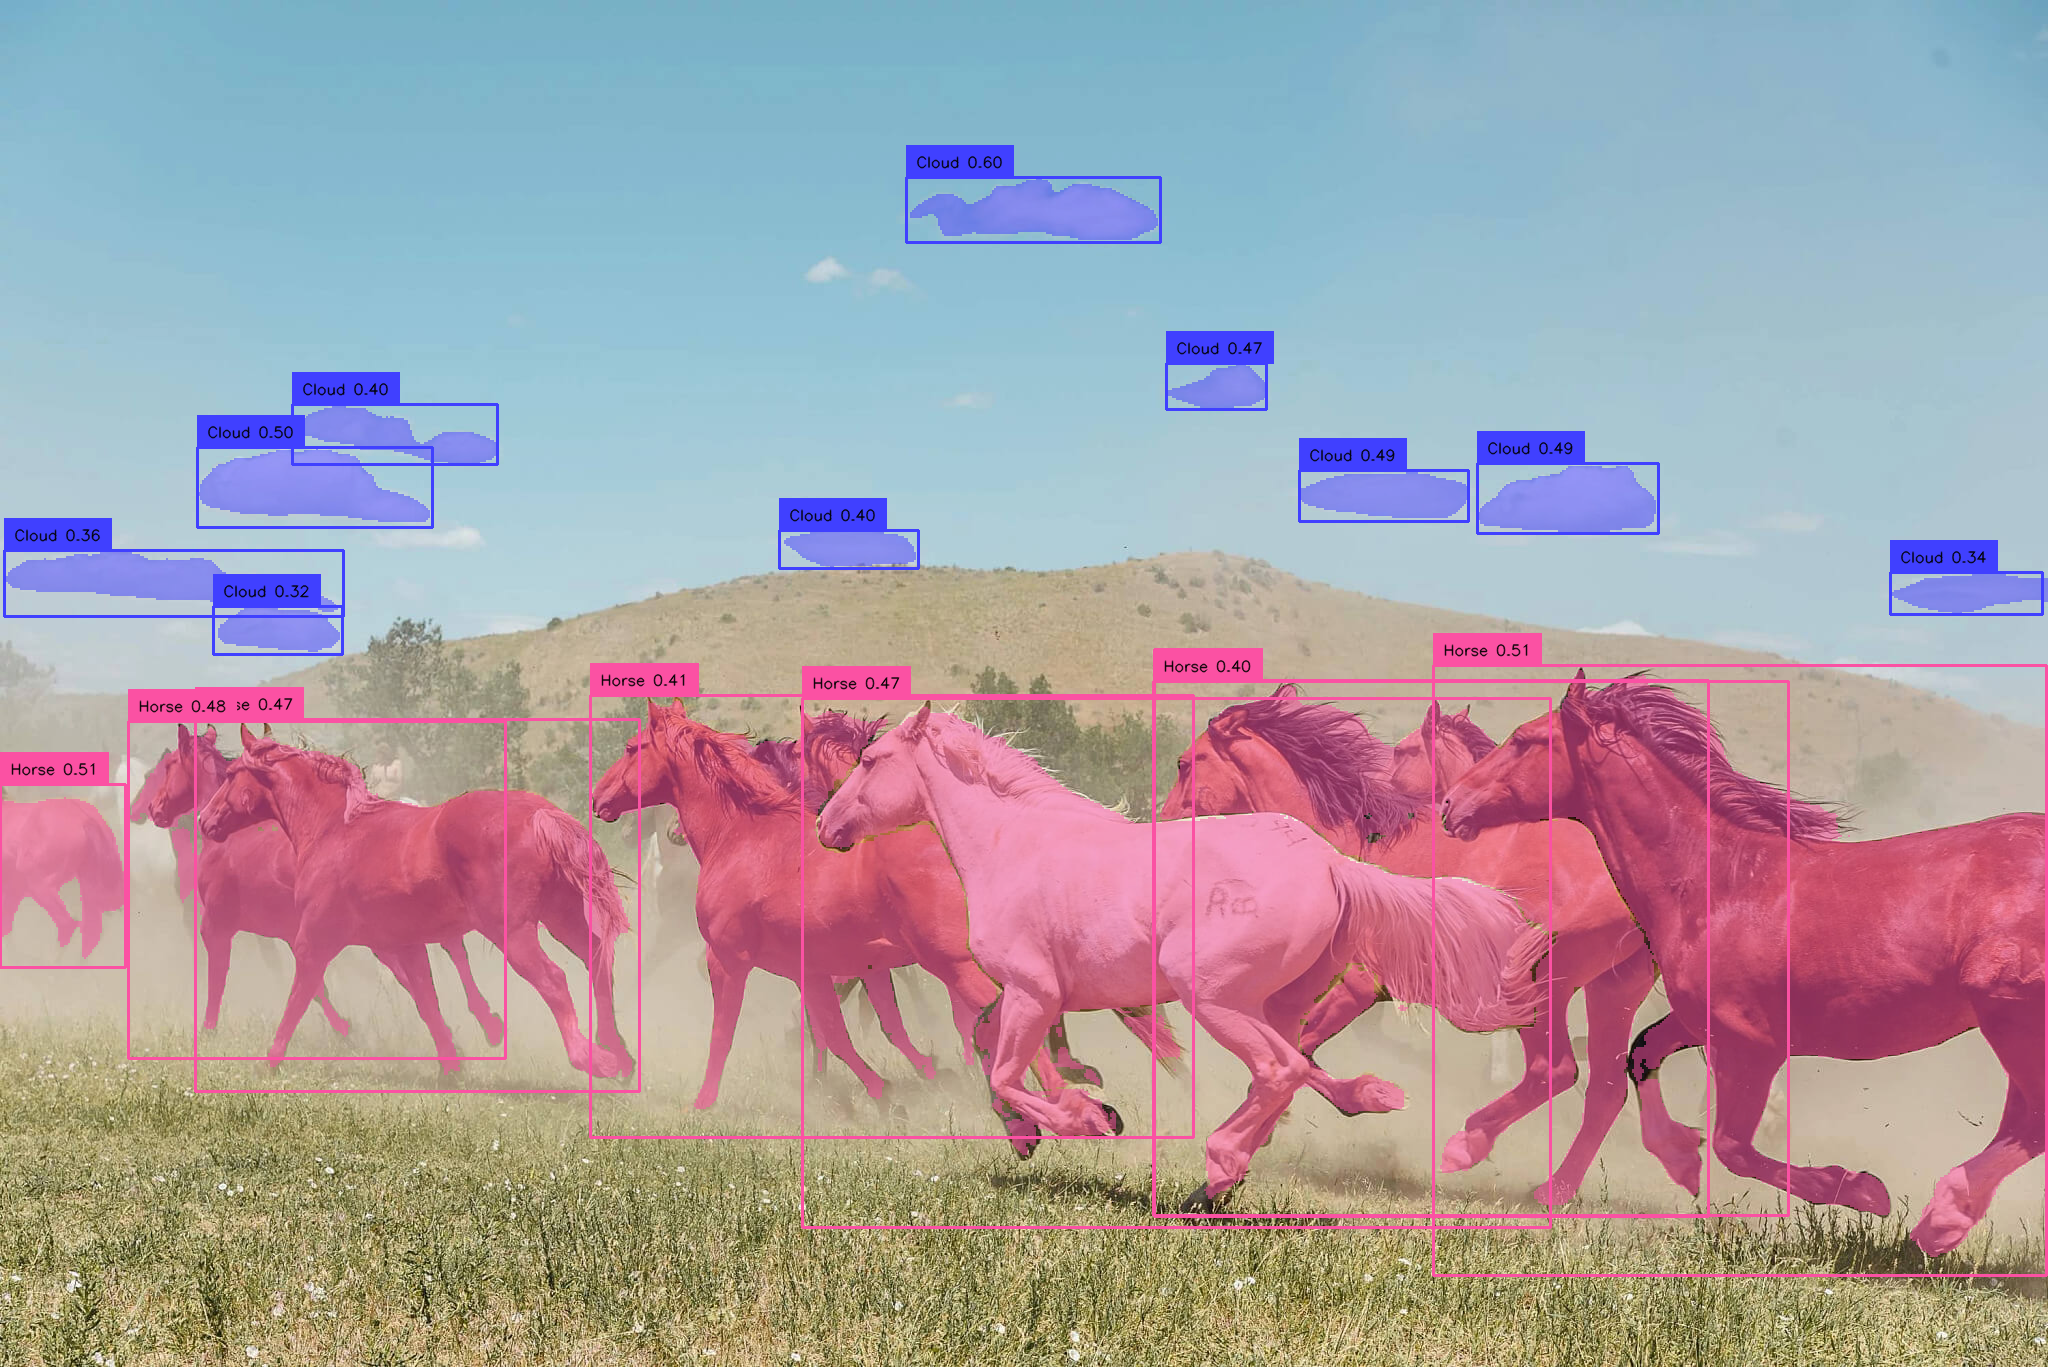

In [27]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

annotated_image = np.array(pil_image)
annotated_image = mask_annotator.annotate(scene=np.array(pil_image).copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

Image.fromarray(annotated_image)

Great! All detected horses and clouds are segmented as well.

### Interactive GroundedSAM
[back to top ⬆️](#Table-of-contents:)

Now, you can try apply grounding sam on your own images using interactive demo. The code below provides helper functions used in demonstration.

In [28]:
def draw_mask(mask, draw, random_color=False):
    import random
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)

def draw_box(box, draw, label):
    # random color
    color = tuple(np.random.randint(0, 255, size=3).tolist())

    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=4)

    if label:
        font = ImageFont.load_default(18)
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((box[0], box[1]), str(label), font, anchor='ld')
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (box[0], box[1], box[0] + w, box[1] + h)
        draw.rectangle(bbox, fill=color)
        draw.text((box[0], box[1]), str(label), fill="white", anchor='ld', font=font)

In [29]:
""""
run_grounding_sam is called every time "Submit" button is clicked
"""
def run_grounding_sam(image, task_type, text_prompt, box_threshold, text_threshold): 
    pil_image = Image.fromarray(image)
    size = image.shape[1], image.shape[0]  # size is WH image.shape HWC
    
    boxes_filt, scores, pred_phrases = get_ov_grounding_output(
        ov_compiled_grounded_dino,
        pil_image,
        text_prompt,
        box_threshold,
        text_threshold
    )

    # process boxes
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()

    if task_type == 'seg':
        if use_efficient_sam:
            masks = predict_efficient_sam_masks(compiled_efficient_sam, pil_image, boxes_filt.numpy())
        else:
            transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(PT_DEVICE)
            masks = predict_vanilla_sam_masks(compiled_vanilla_sam, image, transformed_boxes)[:, 0]

        mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
        mask_draw = ImageDraw.Draw(mask_image)
        for mask in masks:
            draw_mask(mask.cpu().numpy(), mask_draw, random_color=True)

        image_draw = ImageDraw.Draw(pil_image)
        for box, label in zip(boxes_filt, pred_phrases):
            draw_box(box, image_draw, label)

        pil_image = pil_image.convert('RGBA')
        pil_image.alpha_composite(mask_image)

        return [pil_image, mask_image]
    if task_type == 'det':
        image_draw = ImageDraw.Draw(pil_image)
        for box, label in zip(boxes_filt, pred_phrases):
            draw_box(box, image_draw, label)
        return [pil_image]
    else:
        gr.Warning(f"task_type:{task_type} error!")

You can run interactive app with your own image and text prompts. To define prompt specify comma (or conjunction) separated names of objects you wish to segment. For demonstration, this demo already has two predefined examples. If many object are crowded and overlapping please increase threshold values in `Advanced options`.

In [ ]:
import gradio as gr

with gr.Accordion("Advanced options", open=False) as advanced:
    box_threshold = gr.Slider(label="Box Threshold", minimum=0.0, maximum=1.0, value=0.3, step=0.05)
    text_threshold = gr.Slider(label="Text Threshold", minimum=0.0, maximum=1.0, value=0.25, step=0.05)

demo = gr.Interface(
    run_grounding_sam,
    [
        gr.Image(),
        gr.Dropdown(["det", "seg"], value="seg", label="task_type"),
        gr.Textbox(value='bears', label="Text Prompt"),
    ],
    additional_inputs=[
        box_threshold,
        text_threshold,
    ],
    outputs=gr.Gallery(preview=True, object_fit="scale-down"),
    examples=[[f"{repo_dir}/assets/demo1.jpg", "seg", 'bear'], [f"{repo_dir}/assets/demo7.jpg", "seg", 'horses and clouds']],
    additional_inputs_accordion=advanced,
)

try:
    demo.launch(server_name='0.0.0.0', debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

### Cleanup
[back to top ⬆️](#Table-of-contents:)

In [ ]:
# import shutil
# shutil.rmtree(CKPT_BASE_PATH)
# shutil.rmtree(IRS_PATH)